In [2]:
# Import
import os
from PIL import Image

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-01-13 15:40:07.433235: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 15:40:07.464320: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 15:40:07.464349: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 15:40:07.464366: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 15:40:07.470199: I tensorflow/core/platform/cpu_feature_g

# Training (Nitrate)

In [3]:
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/related_sulfate_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :34], ctrl_data[:, 34]
# -------------
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Sulfate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [4]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/sulfate/modified/final_model'  # 모델 저장 경로

epochs = 500  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*2,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=5,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )
    
# define callback
def scheduler(epoch, lr):
    if epoch < 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/sulfate/modified/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-01-13 15:40:35.873252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20387 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-01-13 15:40:35.874950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21447 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-01-13 15:40:35.876481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 21447 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-01-13 15:40:35.878091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21323 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-01-13 15:41:03.046294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 15:41:03.061575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 15:41:03.103314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 15:41:03.236902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 15:41:05.763358: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7face1b30610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-13 15:41:05.763386: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-13 15:41:05.763391: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-13 15:41:05.76339

3/3 [==============================] - ETA: 0s - loss: 5.9024 INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-01-7.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-01-7.75/assets


3/3 [==============================] - 47s 7s/step - loss: 5.9024 - val_loss: 7.7483 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - ETA: 0s - loss: 4.4552INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-02-7.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-02-7.66/assets


3/3 [==============================] - 9s 5s/step - loss: 4.4552 - val_loss: 7.6626 - lr: 0.0010
Epoch 3/500
2/3 [===================>..........] - ETA: 0s - loss: 3.4070INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-03-7.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-03-7.52/assets


3/3 [==============================] - 9s 5s/step - loss: 3.3633 - val_loss: 7.5184 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - ETA: 0s - loss: 2.6071INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-04-7.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-04-7.33/assets


3/3 [==============================] - 10s 5s/step - loss: 2.6071 - val_loss: 7.3334 - lr: 0.0010
Epoch 5/500
2/3 [===================>..........] - ETA: 0s - loss: 2.1721INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-05-7.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-05-7.13/assets


3/3 [==============================] - 9s 5s/step - loss: 2.1501 - val_loss: 7.1296 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - ETA: 0s - loss: 1.7850INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-06-6.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-06-6.92/assets


3/3 [==============================] - 10s 5s/step - loss: 1.7850 - val_loss: 6.9196 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - ETA: 0s - loss: 1.4918INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-07-6.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-07-6.71/assets


3/3 [==============================] - 10s 5s/step - loss: 1.4918 - val_loss: 6.7064 - lr: 0.0010
Epoch 8/500
3/3 [==============================] - ETA: 0s - loss: 1.2730INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-08-6.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-08-6.49/assets


3/3 [==============================] - 10s 5s/step - loss: 1.2730 - val_loss: 6.4897 - lr: 0.0010
Epoch 9/500
3/3 [==============================] - ETA: 0s - loss: 1.1143INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-09-6.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-09-6.27/assets


3/3 [==============================] - 10s 5s/step - loss: 1.1143 - val_loss: 6.2682 - lr: 0.0010
Epoch 10/500
3/3 [==============================] - ETA: 0s - loss: 0.9986INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-10-6.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-10-6.04/assets


3/3 [==============================] - 10s 5s/step - loss: 0.9986 - val_loss: 6.0362 - lr: 0.0010
Epoch 11/500
2/3 [===================>..........] - ETA: 0s - loss: 0.9065INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-11-5.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-11-5.82/assets


3/3 [==============================] - 10s 5s/step - loss: 0.9026 - val_loss: 5.8207 - lr: 0.0010
Epoch 12/500
3/3 [==============================] - ETA: 0s - loss: 0.8267INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-12-5.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-12-5.62/assets


3/3 [==============================] - 10s 5s/step - loss: 0.8267 - val_loss: 5.6208 - lr: 0.0010
Epoch 13/500
3/3 [==============================] - ETA: 0s - loss: 0.7625INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-13-5.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-13-5.44/assets


3/3 [==============================] - 10s 5s/step - loss: 0.7625 - val_loss: 5.4369 - lr: 0.0010
Epoch 14/500
2/3 [===================>..........] - ETA: 0s - loss: 0.7074INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-14-5.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-14-5.26/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7047 - val_loss: 5.2558 - lr: 0.0010
Epoch 15/500
3/3 [==============================] - ETA: 0s - loss: 0.6540INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-15-5.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-15-5.09/assets


3/3 [==============================] - 11s 5s/step - loss: 0.6540 - val_loss: 5.0880 - lr: 0.0010
Epoch 16/500
3/3 [==============================] - ETA: 0s - loss: 0.6093INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-16-4.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-16-4.93/assets


3/3 [==============================] - 10s 5s/step - loss: 0.6093 - val_loss: 4.9327 - lr: 0.0010
Epoch 17/500
3/3 [==============================] - ETA: 0s - loss: 0.5677INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-17-4.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-17-4.79/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5677 - val_loss: 4.7940 - lr: 0.0010
Epoch 18/500
3/3 [==============================] - ETA: 0s - loss: 0.5299INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-18-4.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-18-4.66/assets


3/3 [==============================] - 11s 5s/step - loss: 0.5299 - val_loss: 4.6635 - lr: 0.0010
Epoch 19/500
2/3 [===================>..........] - ETA: 0s - loss: 0.4979INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-19-4.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-19-4.54/assets


3/3 [==============================] - 8s 4s/step - loss: 0.4964 - val_loss: 4.5396 - lr: 0.0010
Epoch 20/500
3/3 [==============================] - ETA: 0s - loss: 0.4652INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-20-4.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-20-4.44/assets


3/3 [==============================] - 11s 6s/step - loss: 0.4652 - val_loss: 4.4406 - lr: 0.0010
Epoch 21/500
3/3 [==============================] - ETA: 0s - loss: 0.4345INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-21-4.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-21-4.33/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4345 - val_loss: 4.3337 - lr: 0.0010
Epoch 22/500
3/3 [==============================] - ETA: 0s - loss: 0.4059INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-22-4.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-22-4.23/assets


3/3 [==============================] - 10s 5s/step - loss: 0.4059 - val_loss: 4.2252 - lr: 0.0010
Epoch 23/500
3/3 [==============================] - ETA: 0s - loss: 0.3803INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-23-4.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-23-4.12/assets


3/3 [==============================] - 10s 5s/step - loss: 0.3803 - val_loss: 4.1225 - lr: 0.0010
Epoch 24/500
3/3 [==============================] - ETA: 0s - loss: 0.3566INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-24-4.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-24-4.03/assets


3/3 [==============================] - 10s 5s/step - loss: 0.3566 - val_loss: 4.0252 - lr: 0.0010
Epoch 25/500
2/3 [===================>..........] - ETA: 0s - loss: 0.3357INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-25-3.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-25-3.92/assets


3/3 [==============================] - 10s 5s/step - loss: 0.3347 - val_loss: 3.9205 - lr: 0.0010
Epoch 26/500
3/3 [==============================] - ETA: 0s - loss: 0.3150INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-26-3.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-26-3.82/assets


3/3 [==============================] - 10s 5s/step - loss: 0.3150 - val_loss: 3.8233 - lr: 0.0010
Epoch 27/500
3/3 [==============================] - ETA: 0s - loss: 0.2959INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-27-3.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-27-3.73/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2959 - val_loss: 3.7286 - lr: 0.0010
Epoch 28/500
3/3 [==============================] - ETA: 0s - loss: 0.2791INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-28-3.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-28-3.62/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2791 - val_loss: 3.6211 - lr: 0.0010
Epoch 29/500
3/3 [==============================] - ETA: 0s - loss: 0.2634INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-29-3.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-29-3.54/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2634 - val_loss: 3.5392 - lr: 0.0010
Epoch 30/500
3/3 [==============================] - ETA: 0s - loss: 0.2481INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-30-3.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-30-3.46/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2481 - val_loss: 3.4621 - lr: 0.0010
Epoch 31/500
3/3 [==============================] - ETA: 0s - loss: 0.2341INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-31-3.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-31-3.39/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2341 - val_loss: 3.3929 - lr: 0.0010
Epoch 32/500
3/3 [==============================] - ETA: 0s - loss: 0.2206INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-32-3.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-32-3.32/assets


3/3 [==============================] - 10s 5s/step - loss: 0.2206 - val_loss: 3.3193 - lr: 0.0010
Epoch 33/500
2/3 [===================>..........] - ETA: 0s - loss: 0.2085INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-33-3.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-33-3.27/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2080 - val_loss: 3.2653 - lr: 0.0010
Epoch 34/500
3/3 [==============================] - ETA: 0s - loss: 0.1962INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-34-3.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-34-3.19/assets


3/3 [==============================] - 11s 5s/step - loss: 0.1962 - val_loss: 3.1933 - lr: 0.0010
Epoch 35/500
3/3 [==============================] - ETA: 0s - loss: 0.1878INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-35-3.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-35-3.10/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1878 - val_loss: 3.1001 - lr: 0.0010
Epoch 36/500
3/3 [==============================] - ETA: 0s - loss: 0.1800INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-36-3.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-36-3.01/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1800 - val_loss: 3.0117 - lr: 0.0010
Epoch 37/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1709INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-37-2.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-37-2.94/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1700 - val_loss: 2.9443 - lr: 0.0010
Epoch 38/500
3/3 [==============================] - 0s 201ms/step - loss: 0.1602 - val_loss: 2.9465 - lr: 0.0010
Epoch 39/500
3/3 [==============================] - ETA: 0s - loss: 0.1518INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-39-2.90/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-39-2.90/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1518 - val_loss: 2.8980 - lr: 0.0010
Epoch 40/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1446INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-40-2.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-40-2.81/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1440 - val_loss: 2.8076 - lr: 0.0010
Epoch 41/500
3/3 [==============================] - ETA: 0s - loss: 0.1351INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-41-2.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-41-2.75/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1351 - val_loss: 2.7537 - lr: 0.0010
Epoch 42/500
3/3 [==============================] - ETA: 0s - loss: 0.1286INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-42-2.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-42-2.72/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1286 - val_loss: 2.7198 - lr: 0.0010
Epoch 43/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1224INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-43-2.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-43-2.68/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1220 - val_loss: 2.6769 - lr: 0.0010
Epoch 44/500
3/3 [==============================] - ETA: 0s - loss: 0.1160INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-44-2.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-44-2.63/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1160 - val_loss: 2.6267 - lr: 0.0010
Epoch 45/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1105INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-45-2.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-45-2.59/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1101 - val_loss: 2.5926 - lr: 0.0010
Epoch 46/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1069INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-46-2.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-46-2.54/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1064 - val_loss: 2.5422 - lr: 0.0010
Epoch 47/500
3/3 [==============================] - ETA: 0s - loss: 0.1010INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-47-2.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-47-2.48/assets


3/3 [==============================] - 10s 5s/step - loss: 0.1010 - val_loss: 2.4764 - lr: 0.0010
Epoch 48/500
3/3 [==============================] - ETA: 0s - loss: 0.0955INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-48-2.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-48-2.43/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0955 - val_loss: 2.4323 - lr: 0.0010
Epoch 49/500
3/3 [==============================] - ETA: 0s - loss: 0.0911INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-49-2.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-49-2.43/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0911 - val_loss: 2.4305 - lr: 0.0010
Epoch 50/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0885INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-50-2.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-50-2.38/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0883 - val_loss: 2.3790 - lr: 0.0010
Epoch 51/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0849INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-51-2.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-51-2.33/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0847 - val_loss: 2.3334 - lr: 0.0010
Epoch 52/500
3/3 [==============================] - ETA: 0s - loss: 0.0814INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-52-2.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-52-2.30/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0814 - val_loss: 2.3034 - lr: 0.0010
Epoch 53/500
3/3 [==============================] - ETA: 0s - loss: 0.0776INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-53-2.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-53-2.28/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0776 - val_loss: 2.2841 - lr: 0.0010
Epoch 54/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0758INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-54-2.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-54-2.26/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0757 - val_loss: 2.2556 - lr: 0.0010
Epoch 55/500
3/3 [==============================] - ETA: 0s - loss: 0.0716INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-55-2.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-55-2.17/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0716 - val_loss: 2.1736 - lr: 0.0010
Epoch 56/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0688INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-56-2.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-56-2.16/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0687 - val_loss: 2.1574 - lr: 0.0010
Epoch 57/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0665 - val_loss: 2.1583 - lr: 0.0010
Epoch 58/500
3/3 [==============================] - ETA: 0s - loss: 0.0637INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-58-2.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-58-2.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0637 - val_loss: 2.0921 - lr: 0.0010
Epoch 59/500
3/3 [==============================] - ETA: 0s - loss: 0.0636INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-59-2.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-59-2.06/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0636 - val_loss: 2.0600 - lr: 0.0010
Epoch 60/500
3/3 [==============================] - ETA: 0s - loss: 0.0616INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-60-2.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-60-2.05/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0616 - val_loss: 2.0498 - lr: 0.0010
Epoch 61/500
3/3 [==============================] - ETA: 0s - loss: 0.0594INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-61-2.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-61-2.04/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0594 - val_loss: 2.0432 - lr: 0.0010
Epoch 62/500
3/3 [==============================] - ETA: 0s - loss: 0.0561INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-62-2.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-62-2.01/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0561 - val_loss: 2.0064 - lr: 0.0010
Epoch 63/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0552 - val_loss: 2.0114 - lr: 0.0010
Epoch 64/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0523INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-64-1.99/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-64-1.99/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0522 - val_loss: 1.9874 - lr: 0.0010
Epoch 65/500
3/3 [==============================] - ETA: 0s - loss: 0.0511INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-65-1.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-65-1.96/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0511 - val_loss: 1.9581 - lr: 0.0010
Epoch 66/500
3/3 [==============================] - 0s 184ms/step - loss: 0.0507 - val_loss: 1.9635 - lr: 0.0010
Epoch 67/500
3/3 [==============================] - 0s 223ms/step - loss: 0.0485 - val_loss: 1.9598 - lr: 0.0010
Epoch 68/500
3/3 [==============================] - ETA: 0s - loss: 0.0459INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-68-1.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-68-1.96/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0459 - val_loss: 1.9551 - lr: 0.0010
Epoch 69/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0448 - val_loss: 1.9641 - lr: 0.0010
Epoch 70/500
3/3 [==============================] - 1s 230ms/step - loss: 0.0444 - val_loss: 1.9762 - lr: 0.0010
Epoch 71/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0435 - val_loss: 1.9573 - lr: 0.0010
Epoch 72/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0417INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-72-1.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-72-1.92/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0416 - val_loss: 1.9194 - lr: 0.0010
Epoch 73/500
3/3 [==============================] - ETA: 0s - loss: 0.0404INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-73-1.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-73-1.88/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0404 - val_loss: 1.8822 - lr: 0.0010
Epoch 74/500
3/3 [==============================] - ETA: 0s - loss: 0.0411INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-74-1.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-74-1.85/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0411 - val_loss: 1.8521 - lr: 0.0010
Epoch 75/500
3/3 [==============================] - ETA: 0s - loss: 0.0409INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-75-1.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-75-1.83/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0409 - val_loss: 1.8338 - lr: 0.0010
Epoch 76/500
3/3 [==============================] - 0s 223ms/step - loss: 0.0398 - val_loss: 1.8387 - lr: 0.0010
Epoch 77/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0383 - val_loss: 1.8422 - lr: 0.0010
Epoch 78/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0365 - val_loss: 1.8669 - lr: 0.0010
Epoch 79/500
3/3 [==============================] - 1s 240ms/step - loss: 0.0355 - val_loss: 1.8511 - lr: 0.0010
Epoch 80/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0349 - val_loss: 1.8450 - lr: 0.0010
Epoch 81/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0352 - val_loss: 1.8343 - lr: 0.0010
Epoch 82/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0342 - val_loss: 1.8602 - lr: 0.0010
Epoch 83/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0334 - val_loss: 1.8772 - lr: 0.001

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-87-1.83/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0305 - val_loss: 1.8309 - lr: 0.0010
Epoch 88/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0309 - val_loss: 1.8484 - lr: 0.0010
Epoch 89/500
3/3 [==============================] - ETA: 0s - loss: 0.0303INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-89-1.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-89-1.81/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0303 - val_loss: 1.8059 - lr: 0.0010
Epoch 90/500
3/3 [==============================] - ETA: 0s - loss: 0.0293INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-90-1.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-90-1.77/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0293 - val_loss: 1.7715 - lr: 0.0010
Epoch 91/500
3/3 [==============================] - ETA: 0s - loss: 0.0290INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-91-1.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-91-1.75/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0290 - val_loss: 1.7503 - lr: 0.0010
Epoch 92/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0286INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-92-1.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-92-1.71/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0286 - val_loss: 1.7143 - lr: 0.0010
Epoch 93/500
3/3 [==============================] - ETA: 0s - loss: 0.0291INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-93-1.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-93-1.67/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0291 - val_loss: 1.6703 - lr: 0.0010
Epoch 94/500
3/3 [==============================] - 1s 236ms/step - loss: 0.0305 - val_loss: 1.6712 - lr: 0.0010
Epoch 95/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0289 - val_loss: 1.6848 - lr: 0.0010
Epoch 96/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0277INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-96-1.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-96-1.66/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0278 - val_loss: 1.6598 - lr: 0.0010
Epoch 97/500
3/3 [==============================] - ETA: 0s - loss: 0.0273INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-97-1.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-97-1.64/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0273 - val_loss: 1.6416 - lr: 0.0010
Epoch 98/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0274INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-98-1.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-98-1.60/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0273 - val_loss: 1.5956 - lr: 0.0010
Epoch 99/500
3/3 [==============================] - ETA: 0s - loss: 0.0268INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-99-1.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-99-1.57/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0268 - val_loss: 1.5652 - lr: 0.0010
Epoch 100/500
3/3 [==============================] - ETA: 0s - loss: 0.0264INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-100-1.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-100-1.52/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0264 - val_loss: 1.5241 - lr: 0.0010
Epoch 101/500
3/3 [==============================] - ETA: 0s - loss: 0.0262INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-101-1.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-101-1.49/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0262 - val_loss: 1.4886 - lr: 0.0010
Epoch 102/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0262INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-102-1.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-102-1.46/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0262 - val_loss: 1.4613 - lr: 0.0010
Epoch 103/500
3/3 [==============================] - ETA: 0s - loss: 0.0258INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-103-1.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-103-1.42/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0258 - val_loss: 1.4183 - lr: 0.0010
Epoch 104/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0267INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-104-1.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-104-1.38/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0265 - val_loss: 1.3752 - lr: 0.0010
Epoch 105/500
3/3 [==============================] - ETA: 0s - loss: 0.0260INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-105-1.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-105-1.34/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0260 - val_loss: 1.3408 - lr: 0.0010
Epoch 106/500
3/3 [==============================] - ETA: 0s - loss: 0.0259INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-106-1.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-106-1.29/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0259 - val_loss: 1.2896 - lr: 0.0010
Epoch 107/500
3/3 [==============================] - ETA: 0s - loss: 0.0253INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-107-1.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-107-1.25/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0253 - val_loss: 1.2501 - lr: 0.0010
Epoch 108/500
3/3 [==============================] - ETA: 0s - loss: 0.0253INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-108-1.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-108-1.19/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0253 - val_loss: 1.1892 - lr: 0.0010
Epoch 109/500
3/3 [==============================] - ETA: 0s - loss: 0.0251INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-109-1.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-109-1.15/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0251 - val_loss: 1.1498 - lr: 0.0010
Epoch 110/500
3/3 [==============================] - ETA: 0s - loss: 0.0252INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-110-1.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-110-1.10/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0252 - val_loss: 1.1011 - lr: 0.0010
Epoch 111/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0255INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-111-1.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-111-1.06/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0254 - val_loss: 1.0619 - lr: 0.0010
Epoch 112/500
3/3 [==============================] - ETA: 0s - loss: 0.0266INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-112-1.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-112-1.02/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0266 - val_loss: 1.0181 - lr: 0.0010
Epoch 113/500
3/3 [==============================] - ETA: 0s - loss: 0.0257INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-113-0.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-113-0.98/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0257 - val_loss: 0.9796 - lr: 0.0010
Epoch 114/500
3/3 [==============================] - ETA: 0s - loss: 0.0254INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-114-0.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-114-0.94/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0254 - val_loss: 0.9439 - lr: 0.0010
Epoch 115/500
3/3 [==============================] - ETA: 0s - loss: 0.0247INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-115-0.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-115-0.91/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0247 - val_loss: 0.9110 - lr: 0.0010
Epoch 116/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0251INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-116-0.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-116-0.88/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0250 - val_loss: 0.8752 - lr: 0.0010
Epoch 117/500
3/3 [==============================] - ETA: 0s - loss: 0.0246INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-117-0.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-117-0.83/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0246 - val_loss: 0.8308 - lr: 0.0010
Epoch 118/500
3/3 [==============================] - ETA: 0s - loss: 0.0241INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-118-0.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-118-0.80/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0241 - val_loss: 0.7989 - lr: 0.0010
Epoch 119/500
3/3 [==============================] - ETA: 0s - loss: 0.0239INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-119-0.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-119-0.77/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0239 - val_loss: 0.7667 - lr: 0.0010
Epoch 120/500
3/3 [==============================] - ETA: 0s - loss: 0.0237INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-120-0.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-120-0.74/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0237 - val_loss: 0.7445 - lr: 0.0010
Epoch 121/500
3/3 [==============================] - ETA: 0s - loss: 0.0242INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-121-0.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-121-0.71/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0242 - val_loss: 0.7093 - lr: 0.0010
Epoch 122/500
3/3 [==============================] - ETA: 0s - loss: 0.0244INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-122-0.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-122-0.67/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0244 - val_loss: 0.6741 - lr: 0.0010
Epoch 123/500
3/3 [==============================] - ETA: 0s - loss: 0.0244INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-123-0.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-123-0.64/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0244 - val_loss: 0.6381 - lr: 0.0010
Epoch 124/500
3/3 [==============================] - ETA: 0s - loss: 0.0243INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-124-0.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-124-0.61/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0243 - val_loss: 0.6101 - lr: 0.0010
Epoch 125/500
3/3 [==============================] - ETA: 0s - loss: 0.0247INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-125-0.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-125-0.58/assets


3/3 [==============================] - 11s 5s/step - loss: 0.0247 - val_loss: 0.5766 - lr: 0.0010
Epoch 126/500
3/3 [==============================] - ETA: 0s - loss: 0.0239INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-126-0.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-126-0.55/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0239 - val_loss: 0.5521 - lr: 0.0010
Epoch 127/500
3/3 [==============================] - ETA: 0s - loss: 0.0237INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-127-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-127-0.52/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0237 - val_loss: 0.5182 - lr: 0.0010
Epoch 128/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0230INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-128-0.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-128-0.48/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0231 - val_loss: 0.4814 - lr: 0.0010
Epoch 129/500
3/3 [==============================] - ETA: 0s - loss: 0.0230INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-129-0.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-129-0.45/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0230 - val_loss: 0.4546 - lr: 0.0010
Epoch 130/500
3/3 [==============================] - ETA: 0s - loss: 0.0229INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-130-0.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-130-0.42/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0229 - val_loss: 0.4222 - lr: 0.0010
Epoch 131/500
3/3 [==============================] - ETA: 0s - loss: 0.0232INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-131-0.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-131-0.41/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0232 - val_loss: 0.4070 - lr: 0.0010
Epoch 132/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0232INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-132-0.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-132-0.39/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0231 - val_loss: 0.3870 - lr: 0.0010
Epoch 133/500
3/3 [==============================] - ETA: 0s - loss: 0.0227INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-133-0.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-133-0.37/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0227 - val_loss: 0.3730 - lr: 0.0010
Epoch 134/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0224INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-134-0.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-134-0.35/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0224 - val_loss: 0.3548 - lr: 0.0010
Epoch 135/500
3/3 [==============================] - ETA: 0s - loss: 0.0224INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-135-0.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-135-0.35/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0224 - val_loss: 0.3467 - lr: 0.0010
Epoch 136/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0229INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-136-0.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-136-0.32/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0229 - val_loss: 0.3220 - lr: 0.0010
Epoch 137/500
3/3 [==============================] - ETA: 0s - loss: 0.0222INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-137-0.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-137-0.32/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0222 - val_loss: 0.3160 - lr: 0.0010
Epoch 138/500
3/3 [==============================] - ETA: 0s - loss: 0.0228INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-138-0.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-138-0.30/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0228 - val_loss: 0.2995 - lr: 0.0010
Epoch 139/500
3/3 [==============================] - ETA: 0s - loss: 0.0224INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-139-0.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-139-0.27/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0224 - val_loss: 0.2657 - lr: 0.0010
Epoch 140/500
3/3 [==============================] - ETA: 0s - loss: 0.0223INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-140-0.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-140-0.26/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0223 - val_loss: 0.2585 - lr: 0.0010
Epoch 141/500
3/3 [==============================] - ETA: 0s - loss: 0.0221INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-141-0.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-141-0.25/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0221 - val_loss: 0.2534 - lr: 0.0010
Epoch 142/500
3/3 [==============================] - ETA: 0s - loss: 0.0223INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-142-0.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-142-0.24/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0223 - val_loss: 0.2353 - lr: 0.0010
Epoch 143/500
3/3 [==============================] - ETA: 0s - loss: 0.0218INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-143-0.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-143-0.22/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0218 - val_loss: 0.2172 - lr: 0.0010
Epoch 144/500
3/3 [==============================] - ETA: 0s - loss: 0.0222INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-144-0.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-144-0.21/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0222 - val_loss: 0.2092 - lr: 0.0010
Epoch 145/500
3/3 [==============================] - ETA: 0s - loss: 0.0219INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-145-0.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-145-0.20/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0219 - val_loss: 0.2033 - lr: 0.0010
Epoch 146/500
3/3 [==============================] - ETA: 0s - loss: 0.0218INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-146-0.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-146-0.19/assets


3/3 [==============================] - 11s 6s/step - loss: 0.0218 - val_loss: 0.1949 - lr: 0.0010
Epoch 147/500
3/3 [==============================] - ETA: 0s - loss: 0.0218INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-147-0.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-147-0.19/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0218 - val_loss: 0.1854 - lr: 0.0010
Epoch 148/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0217INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-148-0.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-148-0.18/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0218 - val_loss: 0.1777 - lr: 0.0010
Epoch 149/500
3/3 [==============================] - ETA: 0s - loss: 0.0216INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-149-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-149-0.16/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0216 - val_loss: 0.1639 - lr: 0.0010
Epoch 150/500
3/3 [==============================] - ETA: 0s - loss: 0.0218INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-150-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-150-0.15/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0218 - val_loss: 0.1520 - lr: 0.0010
Epoch 151/500
3/3 [==============================] - ETA: 0s - loss: 0.0220INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-151-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-151-0.15/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0220 - val_loss: 0.1462 - lr: 0.0010
Epoch 152/500
3/3 [==============================] - ETA: 0s - loss: 0.0219INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-152-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-152-0.14/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0219 - val_loss: 0.1414 - lr: 0.0010
Epoch 153/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0220INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-153-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-153-0.13/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0220 - val_loss: 0.1337 - lr: 0.0010
Epoch 154/500
3/3 [==============================] - ETA: 0s - loss: 0.0220INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-154-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-154-0.13/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0220 - val_loss: 0.1281 - lr: 0.0010
Epoch 155/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0216INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-155-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-155-0.12/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0216 - val_loss: 0.1191 - lr: 0.0010
Epoch 156/500
3/3 [==============================] - ETA: 0s - loss: 0.0216INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-156-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-156-0.11/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0216 - val_loss: 0.1133 - lr: 0.0010
Epoch 157/500
3/3 [==============================] - ETA: 0s - loss: 0.0215INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-157-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-157-0.11/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0215 - val_loss: 0.1124 - lr: 0.0010
Epoch 158/500
3/3 [==============================] - 0s 227ms/step - loss: 0.0214 - val_loss: 0.1131 - lr: 0.0010
Epoch 159/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0216INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-159-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-159-0.11/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0216 - val_loss: 0.1054 - lr: 0.0010
Epoch 160/500
3/3 [==============================] - ETA: 0s - loss: 0.0215INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-160-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-160-0.10/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0215 - val_loss: 0.1017 - lr: 0.0010
Epoch 161/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0216INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-161-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-161-0.10/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0216 - val_loss: 0.0964 - lr: 0.0010
Epoch 162/500
3/3 [==============================] - ETA: 0s - loss: 0.0216INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-162-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-162-0.09/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0216 - val_loss: 0.0922 - lr: 0.0010
Epoch 163/500
3/3 [==============================] - ETA: 0s - loss: 0.0215INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-163-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-163-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0215 - val_loss: 0.0848 - lr: 0.0010
Epoch 164/500
3/3 [==============================] - ETA: 0s - loss: 0.0212INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-164-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-164-0.08/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0212 - val_loss: 0.0822 - lr: 0.0010
Epoch 165/500
3/3 [==============================] - ETA: 0s - loss: 0.0211INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-165-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-165-0.08/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0211 - val_loss: 0.0778 - lr: 0.0010
Epoch 166/500
3/3 [==============================] - ETA: 0s - loss: 0.0213INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-166-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-166-0.08/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0213 - val_loss: 0.0769 - lr: 0.0010
Epoch 167/500
3/3 [==============================] - ETA: 0s - loss: 0.0211INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-167-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-167-0.07/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0211 - val_loss: 0.0707 - lr: 0.0010
Epoch 168/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0213 - val_loss: 0.0728 - lr: 0.0010
Epoch 169/500
3/3 [==============================] - 0s 224ms/step - loss: 0.0214 - val_loss: 0.0725 - lr: 0.0010
Epoch 170/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0214INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-170-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-170-0.07/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0214 - val_loss: 0.0654 - lr: 0.0010
Epoch 171/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0210INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-171-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-171-0.06/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0210 - val_loss: 0.0636 - lr: 0.0010
Epoch 172/500
3/3 [==============================] - ETA: 0s - loss: 0.0213INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-172-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-172-0.06/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0213 - val_loss: 0.0613 - lr: 0.0010
Epoch 173/500
3/3 [==============================] - ETA: 0s - loss: 0.0213INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-173-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-173-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0213 - val_loss: 0.0600 - lr: 0.0010
Epoch 174/500
3/3 [==============================] - ETA: 0s - loss: 0.0215INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-174-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-174-0.06/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0215 - val_loss: 0.0565 - lr: 0.0010
Epoch 175/500
3/3 [==============================] - ETA: 0s - loss: 0.0213INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-175-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-175-0.06/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0213 - val_loss: 0.0564 - lr: 0.0010
Epoch 176/500
3/3 [==============================] - ETA: 0s - loss: 0.0212INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-176-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-176-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0212 - val_loss: 0.0520 - lr: 0.0010
Epoch 177/500
3/3 [==============================] - ETA: 0s - loss: 0.0211INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-177-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-177-0.05/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0211 - val_loss: 0.0518 - lr: 0.0010
Epoch 178/500
3/3 [==============================] - ETA: 0s - loss: 0.0211INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-178-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-178-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0211 - val_loss: 0.0487 - lr: 0.0010
Epoch 179/500
3/3 [==============================] - ETA: 0s - loss: 0.0211INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-179-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-179-0.05/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0211 - val_loss: 0.0482 - lr: 0.0010
Epoch 180/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0210 - val_loss: 0.0508 - lr: 0.0010
Epoch 181/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0211 - val_loss: 0.0489 - lr: 0.0010
Epoch 182/500
3/3 [==============================] - 1s 229ms/step - loss: 0.0210 - val_loss: 0.0508 - lr: 0.0010
Epoch 183/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0216 - val_loss: 0.0504 - lr: 0.0010
Epoch 184/500
3/3 [==============================] - ETA: 0s - loss: 0.0222INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-184-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-184-0.04/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0222 - val_loss: 0.0442 - lr: 0.0010
Epoch 185/500
3/3 [==============================] - 0s 185ms/step - loss: 0.0215 - val_loss: 0.0443 - lr: 0.0010
Epoch 186/500
3/3 [==============================] - ETA: 0s - loss: 0.0217INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-186-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-186-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0217 - val_loss: 0.0410 - lr: 0.0010
Epoch 187/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0214INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-187-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-187-0.04/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0214 - val_loss: 0.0400 - lr: 0.0010
Epoch 188/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0212 - val_loss: 0.0422 - lr: 0.0010
Epoch 189/500
3/3 [==============================] - ETA: 0s - loss: 0.0218INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-189-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-189-0.04/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0218 - val_loss: 0.0392 - lr: 0.0010
Epoch 190/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0212INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-190-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-190-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0212 - val_loss: 0.0387 - lr: 0.0010
Epoch 191/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0210 - val_loss: 0.0391 - lr: 0.0010
Epoch 192/500
3/3 [==============================] - 0s 219ms/step - loss: 0.0212 - val_loss: 0.0387 - lr: 0.0010
Epoch 193/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0213INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-193-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-193-0.04/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0212 - val_loss: 0.0377 - lr: 0.0010
Epoch 194/500
3/3 [==============================] - ETA: 0s - loss: 0.0211INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-194-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-194-0.04/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0211 - val_loss: 0.0375 - lr: 0.0010
Epoch 195/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0212INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-195-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-195-0.04/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0211 - val_loss: 0.0358 - lr: 0.0010
Epoch 196/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0210 - val_loss: 0.0386 - lr: 0.0010
Epoch 197/500
3/3 [==============================] - 0s 224ms/step - loss: 0.0215 - val_loss: 0.0376 - lr: 0.0010
Epoch 198/500
3/3 [==============================] - 0s 181ms/step - loss: 0.0214 - val_loss: 0.0385 - lr: 0.0010
Epoch 199/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0217 - val_loss: 0.0394 - lr: 0.0010
Epoch 200/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0217 - val_loss: 0.0377 - lr: 0.0010
Epoch 201/500
3/3 [==============================] - 1s 225ms/step - loss: 0.0216 - val_loss: 0.0359 - lr: 0.0010
Epoch 202/500
3/3 [==============================] - ETA: 0s - loss: 0.0211INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-202-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-202-0.03/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0211 - val_loss: 0.0334 - lr: 0.0010
Epoch 203/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0207INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-203-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-203-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0207 - val_loss: 0.0310 - lr: 0.0010
Epoch 204/500
3/3 [==============================] - ETA: 0s - loss: 0.0206INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-204-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-204-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0206 - val_loss: 0.0300 - lr: 0.0010
Epoch 205/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0207 - val_loss: 0.0317 - lr: 0.0010
Epoch 206/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0207 - val_loss: 0.0316 - lr: 0.0010
Epoch 207/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0207 - val_loss: 0.0328 - lr: 0.0010
Epoch 208/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0207 - val_loss: 0.0331 - lr: 0.0010
Epoch 209/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0207 - val_loss: 0.0304 - lr: 0.0010
Epoch 210/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0205 - val_loss: 0.0309 - lr: 0.0010
Epoch 211/500
3/3 [==============================] - 0s 186ms/step - loss: 0.0206 - val_loss: 0.0318 - lr: 0.0010
Epoch 212/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0207 - val_loss: 0.0304 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-217-0.03/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0207 - val_loss: 0.0289 - lr: 0.0010
Epoch 218/500
3/3 [==============================] - 0s 220ms/step - loss: 0.0206 - val_loss: 0.0291 - lr: 0.0010
Epoch 219/500
3/3 [==============================] - ETA: 0s - loss: 0.0205INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-219-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-219-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0205 - val_loss: 0.0274 - lr: 0.0010
Epoch 220/500
3/3 [==============================] - 1s 231ms/step - loss: 0.0205 - val_loss: 0.0279 - lr: 0.0010
Epoch 221/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0206 - val_loss: 0.0278 - lr: 0.0010
Epoch 222/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0205 - val_loss: 0.0282 - lr: 0.0010
Epoch 223/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0205 - val_loss: 0.0277 - lr: 0.0010
Epoch 224/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0205 - val_loss: 0.0278 - lr: 0.0010
Epoch 225/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0205 - val_loss: 0.0285 - lr: 0.0010
Epoch 226/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0205 - val_loss: 0.0276 - lr: 0.0010
Epoch 227/500
3/3 [==============================] - 0s 223ms/step - loss: 0.0207 - val_loss: 0.0278 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-229-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0205 - val_loss: 0.0273 - lr: 0.0010
Epoch 230/500
3/3 [==============================] - ETA: 0s - loss: 0.0206INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-230-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-230-0.03/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0206 - val_loss: 0.0261 - lr: 0.0010
Epoch 231/500
3/3 [==============================] - 1s 240ms/step - loss: 0.0204 - val_loss: 0.0272 - lr: 0.0010
Epoch 232/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0204 - val_loss: 0.0283 - lr: 0.0010
Epoch 233/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0206 - val_loss: 0.0278 - lr: 0.0010
Epoch 234/500
3/3 [==============================] - 1s 226ms/step - loss: 0.0206 - val_loss: 0.0274 - lr: 0.0010
Epoch 235/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0206 - val_loss: 0.0268 - lr: 0.0010
Epoch 236/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0205INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-236-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-236-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0205 - val_loss: 0.0260 - lr: 0.0010
Epoch 237/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0204INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-237-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-237-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0204 - val_loss: 0.0258 - lr: 0.0010
Epoch 238/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0203INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-238-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-238-0.02/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0203 - val_loss: 0.0249 - lr: 0.0010
Epoch 239/500
3/3 [==============================] - ETA: 0s - loss: 0.0203INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-239-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-239-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0203 - val_loss: 0.0241 - lr: 0.0010
Epoch 240/500
3/3 [==============================] - ETA: 0s - loss: 0.0204INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-240-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-240-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0204 - val_loss: 0.0240 - lr: 0.0010
Epoch 241/500
3/3 [==============================] - ETA: 0s - loss: 0.0206INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-241-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-241-0.02/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0206 - val_loss: 0.0240 - lr: 0.0010
Epoch 242/500
3/3 [==============================] - ETA: 0s - loss: 0.0204INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-242-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-242-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0204 - val_loss: 0.0240 - lr: 0.0010
Epoch 243/500
3/3 [==============================] - 0s 226ms/step - loss: 0.0205 - val_loss: 0.0253 - lr: 0.0010
Epoch 244/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0203 - val_loss: 0.0255 - lr: 0.0010
Epoch 245/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0202 - val_loss: 0.0262 - lr: 0.0010
Epoch 246/500
3/3 [==============================] - 1s 236ms/step - loss: 0.0203 - val_loss: 0.0281 - lr: 0.0010
Epoch 247/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0206 - val_loss: 0.0282 - lr: 0.0010
Epoch 248/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0208 - val_loss: 0.0271 - lr: 0.0010
Epoch 249/500
3/3 [==============================] - 0s 222ms/step - loss: 0.0207 - val_loss: 0.0257 - lr: 0.0010
Epoch 250/500
3/3 [==============================] - 0s 190ms/step - loss: 0.0205 - val_loss: 0.0260 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-270-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0204 - val_loss: 0.0238 - lr: 0.0010
Epoch 271/500
3/3 [==============================] - ETA: 0s - loss: 0.0202INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-271-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-271-0.02/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0202 - val_loss: 0.0235 - lr: 0.0010
Epoch 272/500
3/3 [==============================] - 0s 220ms/step - loss: 0.0204 - val_loss: 0.0238 - lr: 0.0010
Epoch 273/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0201 - val_loss: 0.0251 - lr: 0.0010
Epoch 274/500
3/3 [==============================] - 1s 235ms/step - loss: 0.0202 - val_loss: 0.0250 - lr: 0.0010
Epoch 275/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0203 - val_loss: 0.0239 - lr: 0.0010
Epoch 276/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0202 - val_loss: 0.0244 - lr: 0.0010
Epoch 277/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0202 - val_loss: 0.0242 - lr: 0.0010
Epoch 278/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0202 - val_loss: 0.0249 - lr: 0.0010
Epoch 279/500
3/3 [==============================] - 1s 239ms/step - loss: 0.0206 - val_loss: 0.0240 - l

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-282-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0206 - val_loss: 0.0233 - lr: 0.0010
Epoch 283/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0202 - val_loss: 0.0236 - lr: 0.0010
Epoch 284/500
3/3 [==============================] - 0s 190ms/step - loss: 0.0202 - val_loss: 0.0239 - lr: 0.0010
Epoch 285/500
3/3 [==============================] - ETA: 0s - loss: 0.0202INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-285-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-285-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0202 - val_loss: 0.0232 - lr: 0.0010
Epoch 286/500
3/3 [==============================] - ETA: 0s - loss: 0.0201INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-286-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-286-0.02/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0201 - val_loss: 0.0230 - lr: 0.0010
Epoch 287/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0200 - val_loss: 0.0233 - lr: 0.0010
Epoch 288/500
3/3 [==============================] - 1s 234ms/step - loss: 0.0201 - val_loss: 0.0234 - lr: 0.0010
Epoch 289/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0201 - val_loss: 0.0231 - lr: 0.0010
Epoch 290/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0201INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-290-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-290-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0200 - val_loss: 0.0230 - lr: 0.0010
Epoch 291/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0200 - val_loss: 0.0238 - lr: 0.0010
Epoch 292/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0202 - val_loss: 0.0252 - lr: 0.0010
Epoch 293/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0206 - val_loss: 0.0255 - lr: 0.0010
Epoch 294/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0209 - val_loss: 0.0264 - lr: 0.0010
Epoch 295/500
3/3 [==============================] - 1s 242ms/step - loss: 0.0212 - val_loss: 0.0267 - lr: 0.0010
Epoch 296/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0213 - val_loss: 0.0260 - lr: 0.0010
Epoch 297/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0211 - val_loss: 0.0245 - lr: 0.0010
Epoch 298/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0206 - val_loss: 0.0258 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-305-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0202 - val_loss: 0.0219 - lr: 0.0010
Epoch 306/500
3/3 [==============================] - ETA: 0s - loss: 0.0202INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-306-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-306-0.02/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0202 - val_loss: 0.0218 - lr: 0.0010
Epoch 307/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0202 - val_loss: 0.0219 - lr: 0.0010
Epoch 308/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0200 - val_loss: 0.0221 - lr: 0.0010
Epoch 309/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0200 - val_loss: 0.0229 - lr: 0.0010
Epoch 310/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0202 - val_loss: 0.0234 - lr: 0.0010
Epoch 311/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0204 - val_loss: 0.0235 - lr: 0.0010
Epoch 312/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0203 - val_loss: 0.0234 - lr: 0.0010
Epoch 313/500
3/3 [==============================] - 1s 229ms/step - loss: 0.0204 - val_loss: 0.0239 - lr: 0.0010
Epoch 314/500
3/3 [==============================] - 0s 215ms/step - loss: 0.0203 - val_loss: 0.0235 - l

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-325-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0201 - val_loss: 0.0217 - lr: 0.0010
Epoch 326/500
3/3 [==============================] - ETA: 0s - loss: 0.0202INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-326-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-326-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0202 - val_loss: 0.0217 - lr: 0.0010
Epoch 327/500
3/3 [==============================] - ETA: 0s - loss: 0.0201INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-327-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-327-0.02/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0201 - val_loss: 0.0217 - lr: 0.0010
Epoch 328/500
3/3 [==============================] - ETA: 0s - loss: 0.0199INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-328-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-328-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0199 - val_loss: 0.0217 - lr: 0.0010
Epoch 329/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0200 - val_loss: 0.0219 - lr: 0.0010
Epoch 330/500
3/3 [==============================] - ETA: 0s - loss: 0.0201INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-330-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-330-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0201 - val_loss: 0.0217 - lr: 0.0010
Epoch 331/500
3/3 [==============================] - ETA: 0s - loss: 0.0204INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-331-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-331-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0204 - val_loss: 0.0214 - lr: 0.0010
Epoch 332/500
3/3 [==============================] - 0s 190ms/step - loss: 0.0202 - val_loss: 0.0215 - lr: 0.0010
Epoch 333/500
3/3 [==============================] - 0s 215ms/step - loss: 0.0204 - val_loss: 0.0216 - lr: 0.0010
Epoch 334/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0203 - val_loss: 0.0222 - lr: 0.0010
Epoch 335/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0202 - val_loss: 0.0219 - lr: 0.0010
Epoch 336/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0200 - val_loss: 0.0217 - lr: 0.0010
Epoch 337/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0199 - val_loss: 0.0216 - lr: 0.0010
Epoch 338/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0199 - val_loss: 0.0217 - lr: 0.0010
Epoch 339/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0203 - val_loss: 0.0215 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-365-0.02/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0199 - val_loss: 0.0214 - lr: 0.0010
Epoch 366/500
3/3 [==============================] - ETA: 0s - loss: 0.0205INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-366-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-366-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0205 - val_loss: 0.0213 - lr: 0.0010
Epoch 367/500
3/3 [==============================] - ETA: 0s - loss: 0.0202INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-367-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-367-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0202 - val_loss: 0.0211 - lr: 0.0010
Epoch 368/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0200INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-368-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-368-0.02/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0200 - val_loss: 0.0211 - lr: 0.0010
Epoch 369/500
3/3 [==============================] - 0s 220ms/step - loss: 0.0201 - val_loss: 0.0213 - lr: 0.0010
Epoch 370/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0199 - val_loss: 0.0213 - lr: 0.0010
Epoch 371/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0199 - val_loss: 0.0214 - lr: 0.0010
Epoch 372/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0199 - val_loss: 0.0215 - lr: 0.0010
Epoch 373/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0198 - val_loss: 0.0214 - lr: 0.0010
Epoch 374/500
3/3 [==============================] - 0s 187ms/step - loss: 0.0203 - val_loss: 0.0214 - lr: 0.0010
Epoch 375/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0205 - val_loss: 0.0212 - lr: 0.0010
Epoch 376/500
3/3 [==============================] - 0s 220ms/step - loss: 0.0200 - val_loss: 0.0214 - l

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-382-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0199 - val_loss: 0.0210 - lr: 0.0010
Epoch 383/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0198 - val_loss: 0.0211 - lr: 0.0010
Epoch 384/500
3/3 [==============================] - ETA: 0s - loss: 0.0198INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-384-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-384-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0198 - val_loss: 0.0210 - lr: 0.0010
Epoch 385/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0198 - val_loss: 0.0211 - lr: 0.0010
Epoch 386/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0198 - val_loss: 0.0213 - lr: 0.0010
Epoch 387/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0197 - val_loss: 0.0222 - lr: 0.0010
Epoch 388/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0199 - val_loss: 0.0220 - lr: 0.0010
Epoch 389/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0199 - val_loss: 0.0231 - lr: 0.0010
Epoch 390/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0202 - val_loss: 0.0227 - lr: 0.0010
Epoch 391/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0200 - val_loss: 0.0217 - lr: 0.0010
Epoch 392/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0199 - val_loss: 0.0218 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-396-0.02/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0197 - val_loss: 0.0209 - lr: 0.0010
Epoch 397/500
3/3 [==============================] - ETA: 0s - loss: 0.0197INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-397-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-397-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0197 - val_loss: 0.0208 - lr: 0.0010
Epoch 398/500
3/3 [==============================] - ETA: 0s - loss: 0.0200INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-398-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-398-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0200 - val_loss: 0.0207 - lr: 0.0010
Epoch 399/500
3/3 [==============================] - 0s 185ms/step - loss: 0.0200 - val_loss: 0.0208 - lr: 0.0010
Epoch 400/500
3/3 [==============================] - 0s 179ms/step - loss: 0.0200 - val_loss: 0.0209 - lr: 0.0010
Epoch 401/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0198 - val_loss: 0.0209 - lr: 0.0010
Epoch 402/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0198 - val_loss: 0.0210 - lr: 0.0010
Epoch 403/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0197 - val_loss: 0.0209 - lr: 0.0010
Epoch 404/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0197 - val_loss: 0.0208 - lr: 0.0010
Epoch 405/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0197 - val_loss: 0.0208 - lr: 0.0010
Epoch 406/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0198 - val_loss: 0.0210 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-418-0.02/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0198 - val_loss: 0.0206 - lr: 0.0010
Epoch 419/500
3/3 [==============================] - ETA: 0s - loss: 0.0198INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-419-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-419-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0198 - val_loss: 0.0205 - lr: 0.0010
Epoch 420/500
3/3 [==============================] - 1s 231ms/step - loss: 0.0198 - val_loss: 0.0207 - lr: 0.0010
Epoch 421/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0199 - val_loss: 0.0205 - lr: 0.0010
Epoch 422/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0198 - val_loss: 0.0209 - lr: 0.0010
Epoch 423/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0202 - val_loss: 0.0208 - lr: 0.0010
Epoch 424/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0205 - val_loss: 0.0206 - lr: 0.0010
Epoch 425/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0202 - val_loss: 0.0210 - lr: 0.0010
Epoch 426/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0199 - val_loss: 0.0210 - lr: 0.0010
Epoch 427/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0201 - val_loss: 0.0207 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-473-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0201 - val_loss: 0.0204 - lr: 0.0010
Epoch 474/500
3/3 [==============================] - ETA: 0s - loss: 0.0200INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-474-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model-474-0.02/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0200 - val_loss: 0.0202 - lr: 0.0010
Epoch 475/500
3/3 [==============================] - 1s 261ms/step - loss: 0.0198 - val_loss: 0.0203 - lr: 0.0010
Epoch 476/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0198 - val_loss: 0.0204 - lr: 0.0010
Epoch 477/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0198 - val_loss: 0.0205 - lr: 0.0010
Epoch 478/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0196 - val_loss: 0.0204 - lr: 0.0010
Epoch 479/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0197 - val_loss: 0.0207 - lr: 0.0010
Epoch 480/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0197 - val_loss: 0.0207 - lr: 0.0010
Epoch 481/500
3/3 [==============================] - 1s 241ms/step - loss: 0.0197 - val_loss: 0.0206 - lr: 0.0010
Epoch 482/500
3/3 [==============================] - 0s 187ms/step - loss: 0.0197 - val_loss: 0.0206 - l

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/sulfate/modified/final_model/assets


' '

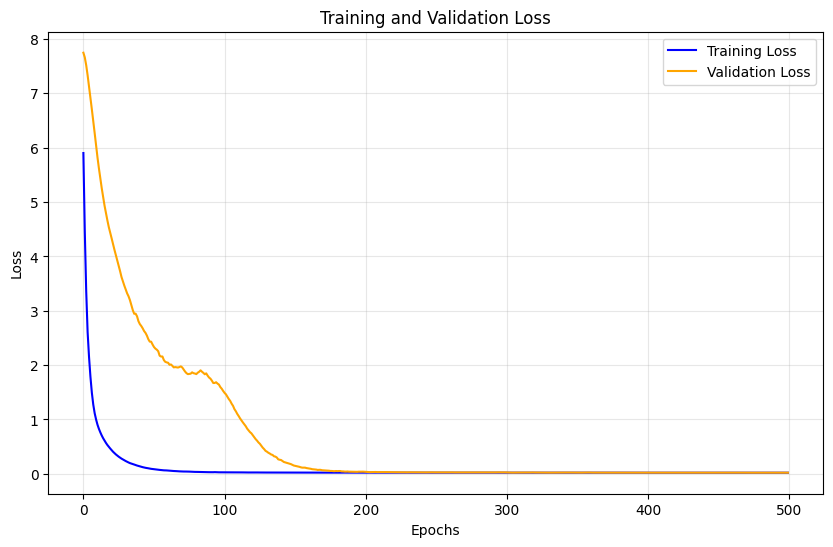

In [5]:
plot_loss(history)

# Prediction & Performance

In [6]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [8]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/sulfate/modified/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/related_sulfate_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Sulfate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :34], ctrl_data[:, 34]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 1s 304ms/step


In [9]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [10]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

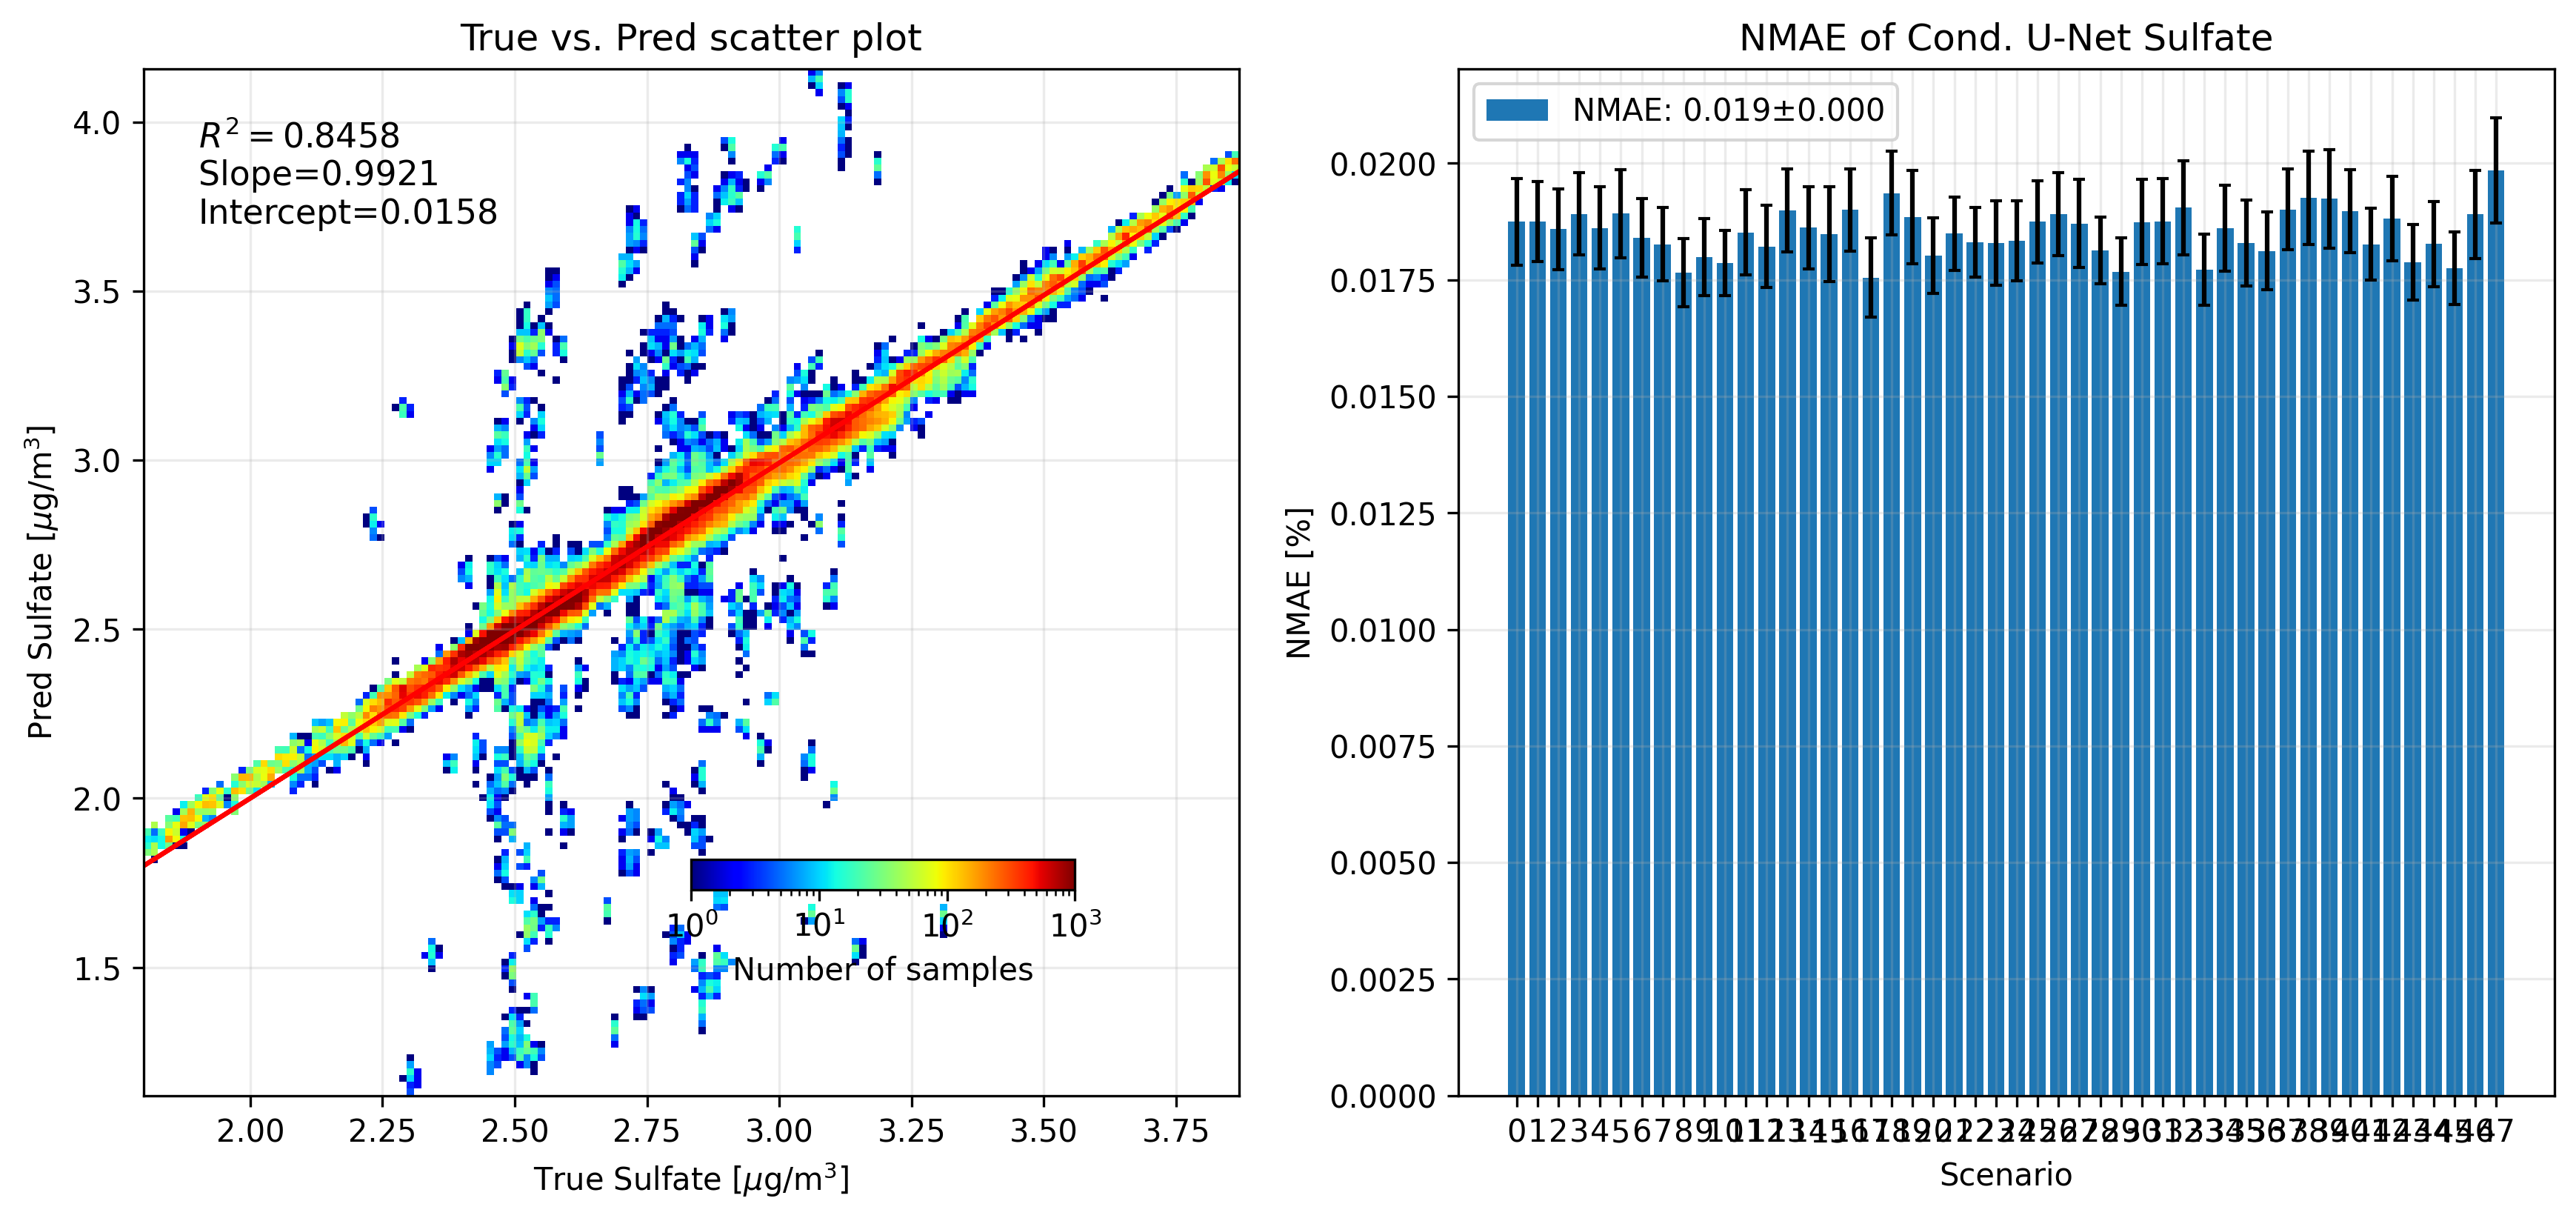

In [11]:
y_pred_ori = y_pred.reshape(-1)
y_true_ori = y_true.reshape(-1)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_ori, y_pred_ori)
axes[0].grid(alpha=0.25)
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Sulfate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Sulfate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_ori = y_test.reshape(y_test.shape[0], -1)
y_pred_ori = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Sulfate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')
plt.show()

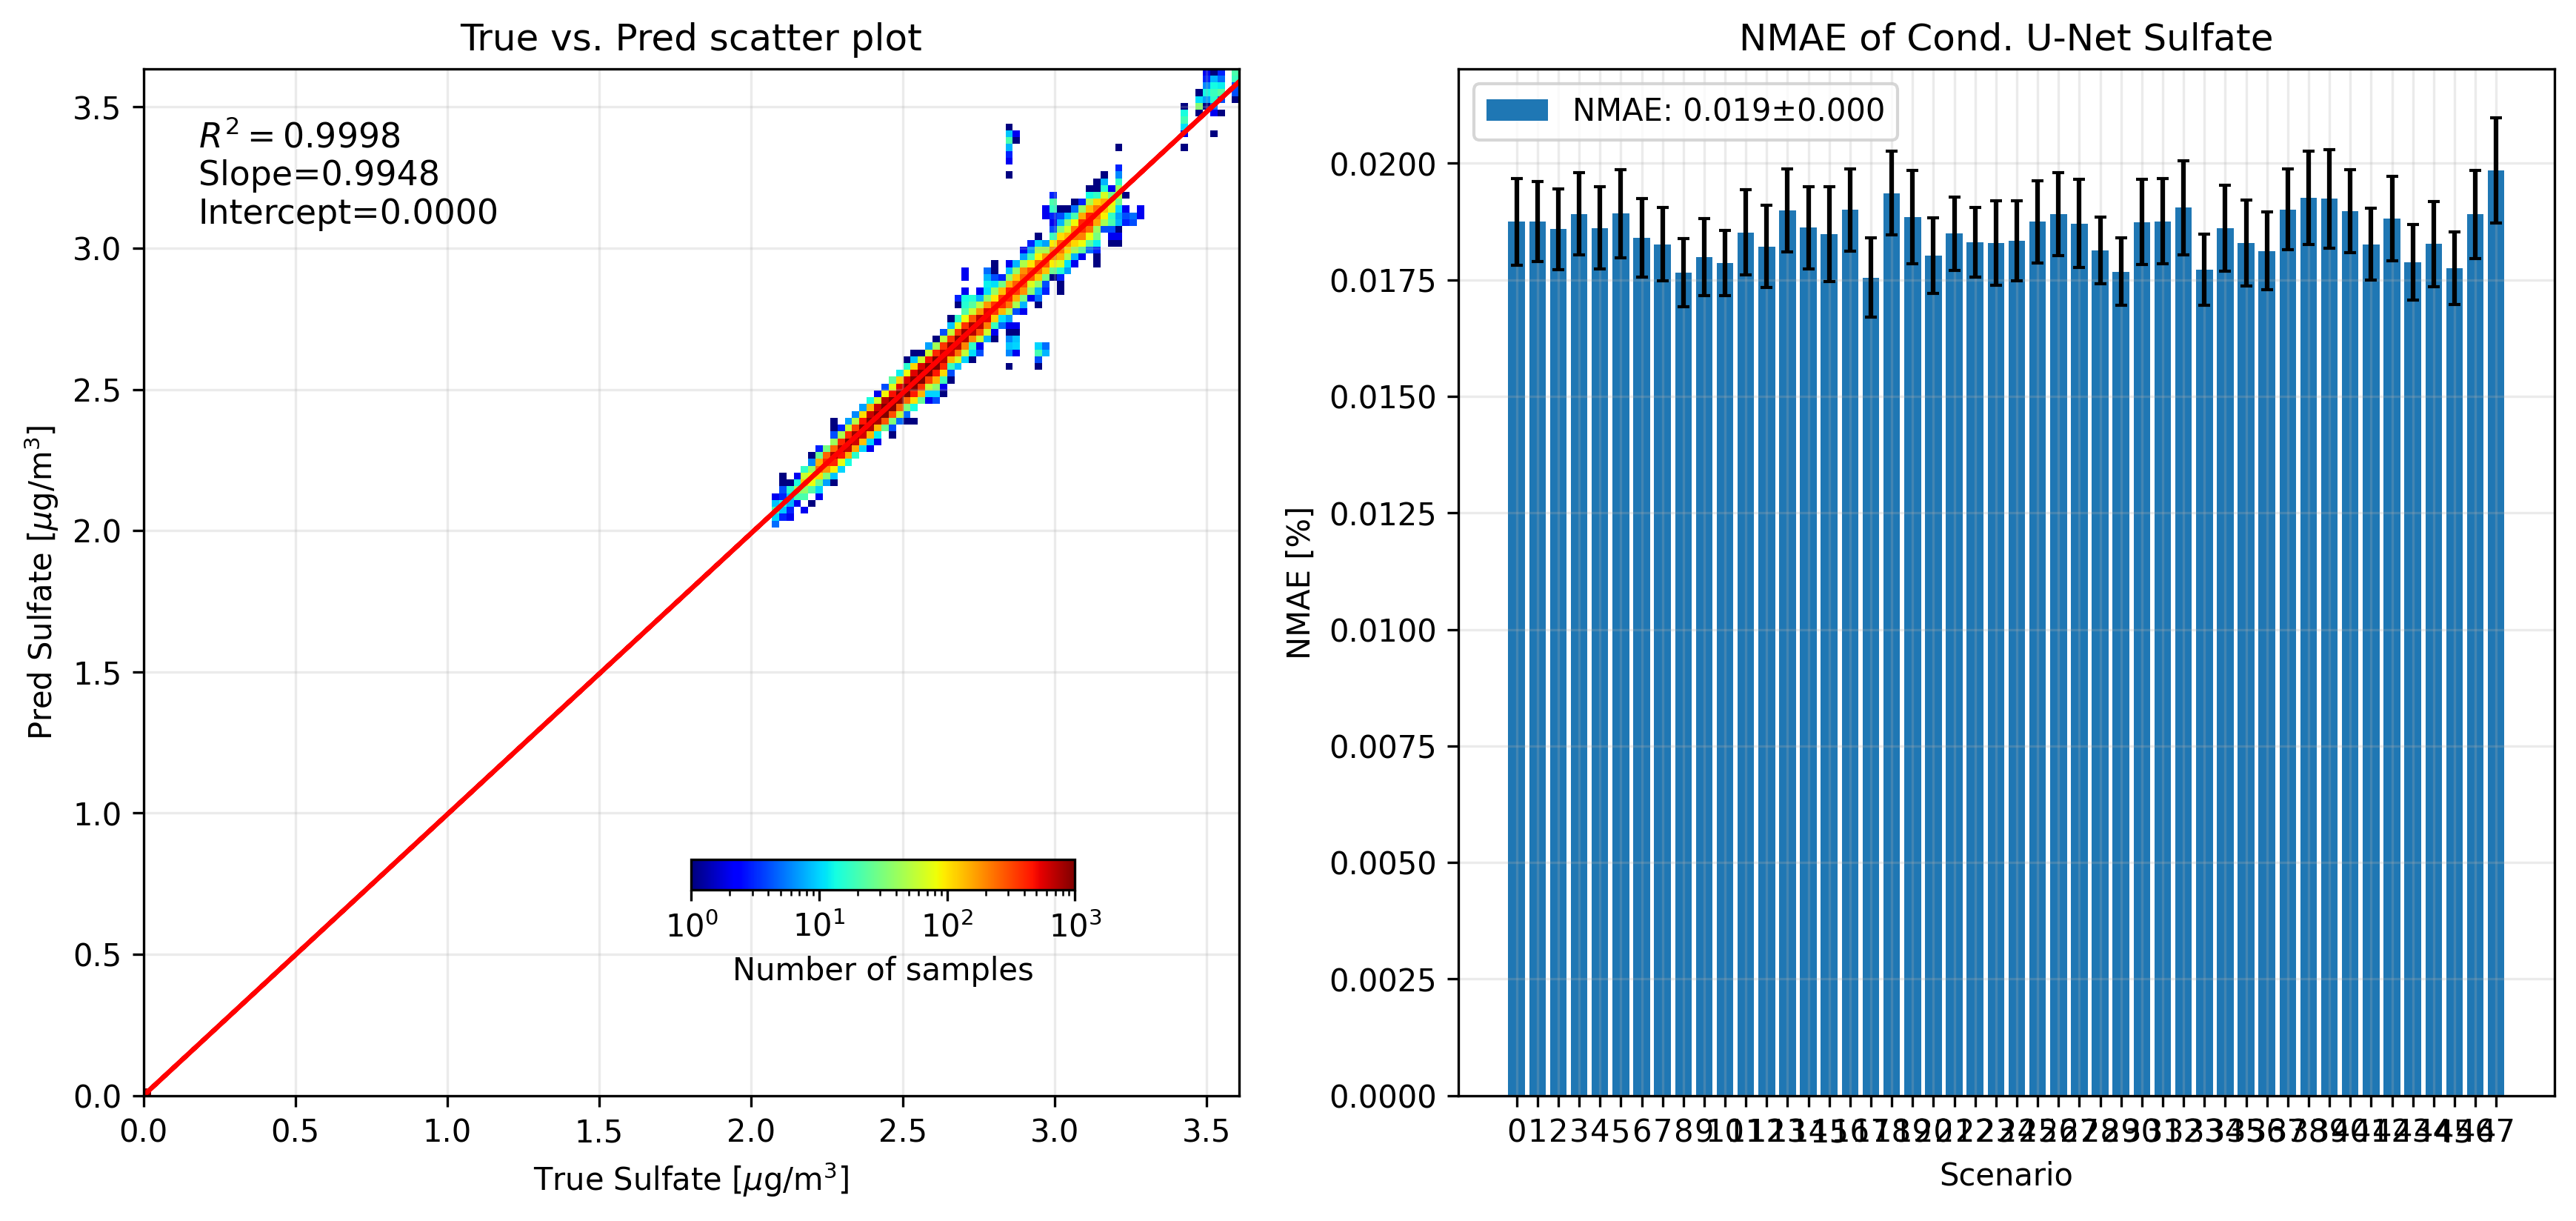

In [12]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_modi, y_pred_modi)
axes[0].grid(alpha=0.25)
# axes[0].set_xlim(3, 67)  # True 축 범위를 조정
# axes[0].set_ylim(3, 69)  # Pred 축 범위를 조정
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Sulfate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Sulfate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_modi = y_test.reshape(y_test.shape[0], -1)
y_pred_modi = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true_modi, y_pred_modi)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Sulfate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')

plt.show()

In [13]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


[42]


/tmp/ipykernel_1350485/3969457850.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1350485/3969457850.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1350485/3969457850.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1350485/3969457850.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1350485/3969457850.py:62: UserWarning: set_ti

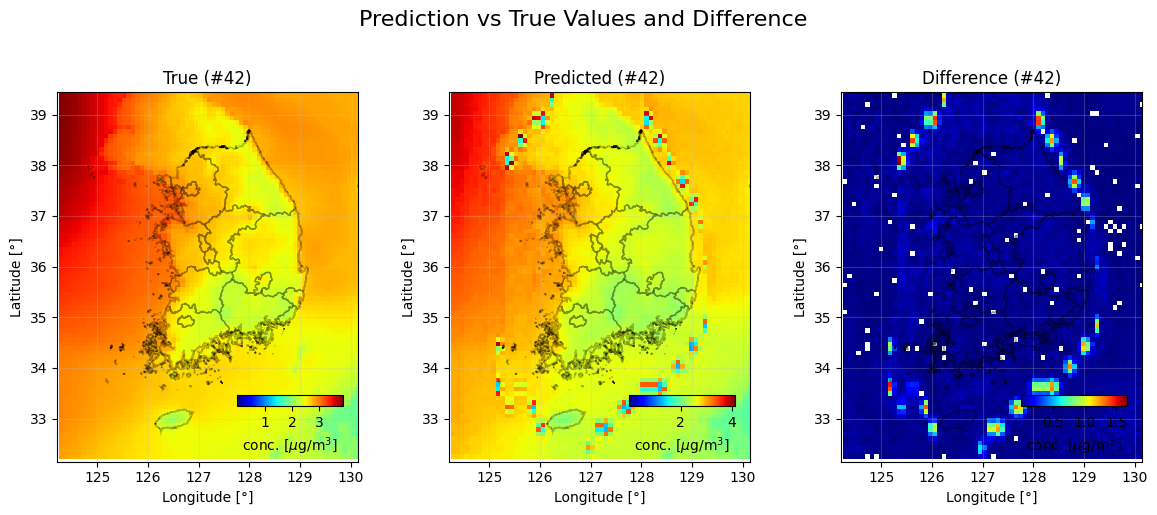

[1]


/tmp/ipykernel_1350485/3969457850.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1350485/3969457850.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1350485/3969457850.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1350485/3969457850.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1350485/3969457850.py:62: UserWarning: set_ti

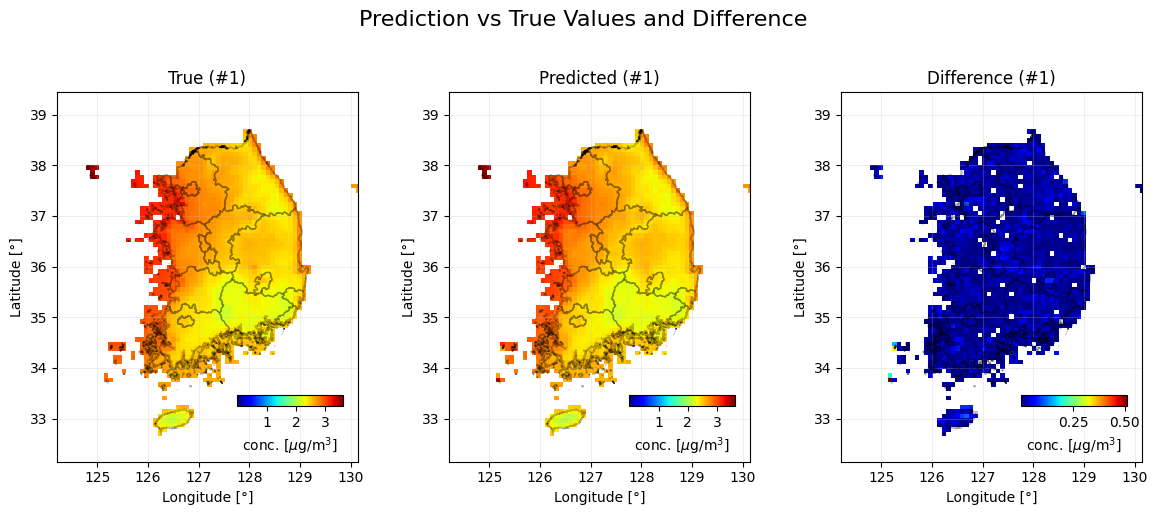

In [14]:
def plot_prediction_loss(y_true, y_pred, num_samples=1):
    indices = np.random.choice(len(y_true), num_samples, replace=False)
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Sulfate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Sulfate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Sulfate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(y_true, y_pred)
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines)

[42]


/tmp/ipykernel_1350485/3969457850.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1350485/3969457850.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1350485/3969457850.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1350485/3969457850.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1350485/3969457850.py:62: UserWarning: set_ti

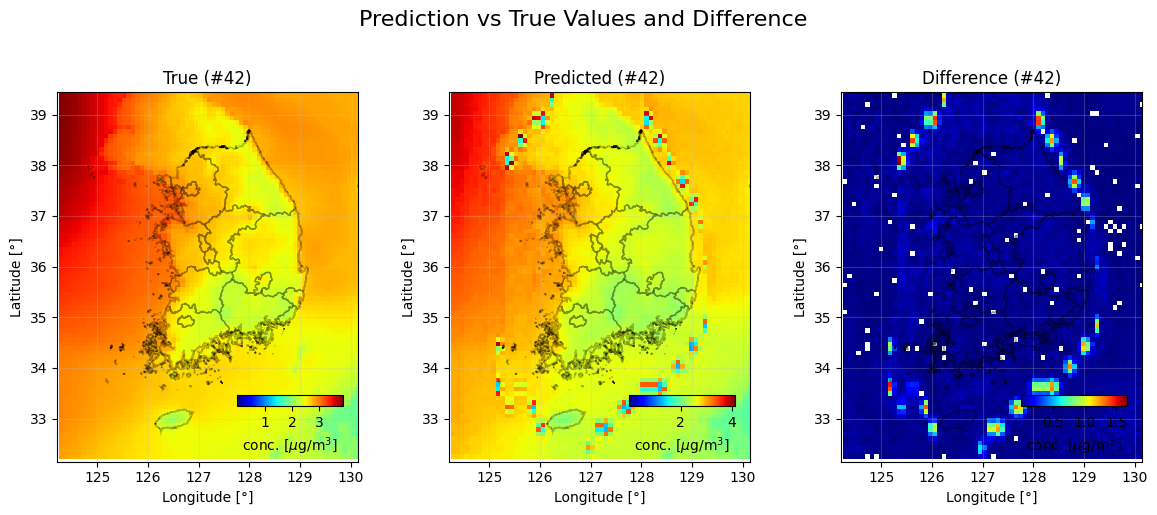

[1]


/tmp/ipykernel_1350485/3969457850.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1350485/3969457850.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1350485/3969457850.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1350485/3969457850.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1350485/3969457850.py:62: UserWarning: set_ti

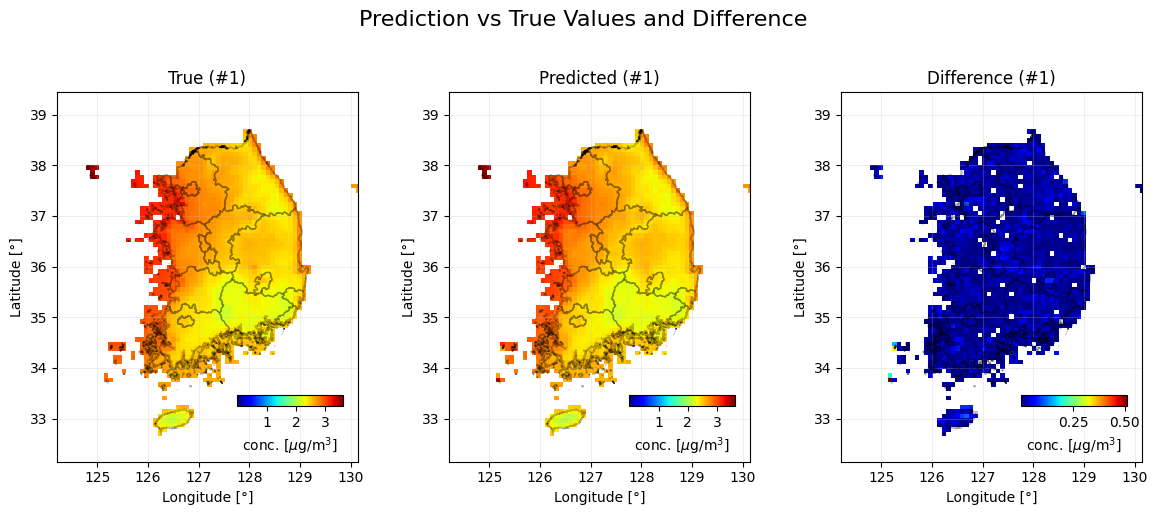

In [ ]:
def plot_prediction_loss(y_true, y_pred, num_samples=1):
    indices = np.random.choice(len(y_true), num_samples, replace=False)
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Sulfate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Sulfate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Sulfate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(y_true, y_pred)
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines)

In [13]:
tf.keras.backend.clear_session()